In [1]:
from google.colab import files
files.upload()

In [ ]:
!unzip /content/train_SOaYf6m.zip 

Archive:  /content/train_SOaYf6m.zip
   creating: images/
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         
  inflating: images/1018.jpg         
  inflating: images/1019.jpg  

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models,transforms
from torch.utils.data import Dataset,random_split,DataLoader
import numpy as np
import cv2
import glob
from torch.optim.lr_scheduler import StepLR
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
train_csv=pd.read_csv("/content/train.csv")
test_csv=pd.read_csv("/content/test.csv")
sample_csv=pd.read_csv("/content/sample_submission.csv")

In [ ]:
train_csv.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [ ]:
len(sample_csv),len(test_csv)

(706, 706)

In [ ]:
train_csv.emergency_or_not.value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

In [ ]:
test_csv.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [ ]:
train_csv.describe()

,emergency_or_not
count,1646.000000
mean,0.413730
std,0.492651
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
len(train_csv)

1646

In [ ]:
class Mydataset(nn.Module):
  def __init__(self,df,transform=False):
    self.df=df
    self.transform=transform
    
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    y=self.df.emergency_or_not.values[idx]
    n=self.df.image_names.values[idx]
    name=os.path.join("/content/images",n)
    img=cv2.imread(name)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img= transforms.ToPILImage()(img)
    if self.transform:
      img=transform(img)
    return img,y

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
test_ds=Mydataset(sample_csv,transform=transform)
test_loader=DataLoader(test_ds,batch_size=60)

In [ ]:
len(test_ds)

706

In [ ]:
train_ds=Mydataset(train_csv,transform=transform)
train,test=random_split(train_ds,[1000,len(train_ds)-1000])
train_loader=DataLoader(train,batch_size=100,shuffle=True,num_workers=4)
val_loader=DataLoader(test,batch_size=100,shuffle=True,num_workers=4)

In [ ]:
img,lab=next(iter(train_loader))

In [ ]:
img.shape

torch.Size([100, 3, 224, 224])

In [ ]:
def plotme(data):
  img,lab=next(iter(data))
  fig=plt.figure(figsize=(20,20))
  for i in range(1,11):
    inp=img[i].numpy().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig.add_subplot(5,2,i)
    plt.imshow(inp)
    plt.title(str(lab[i].item()))
    fig.add_subplot

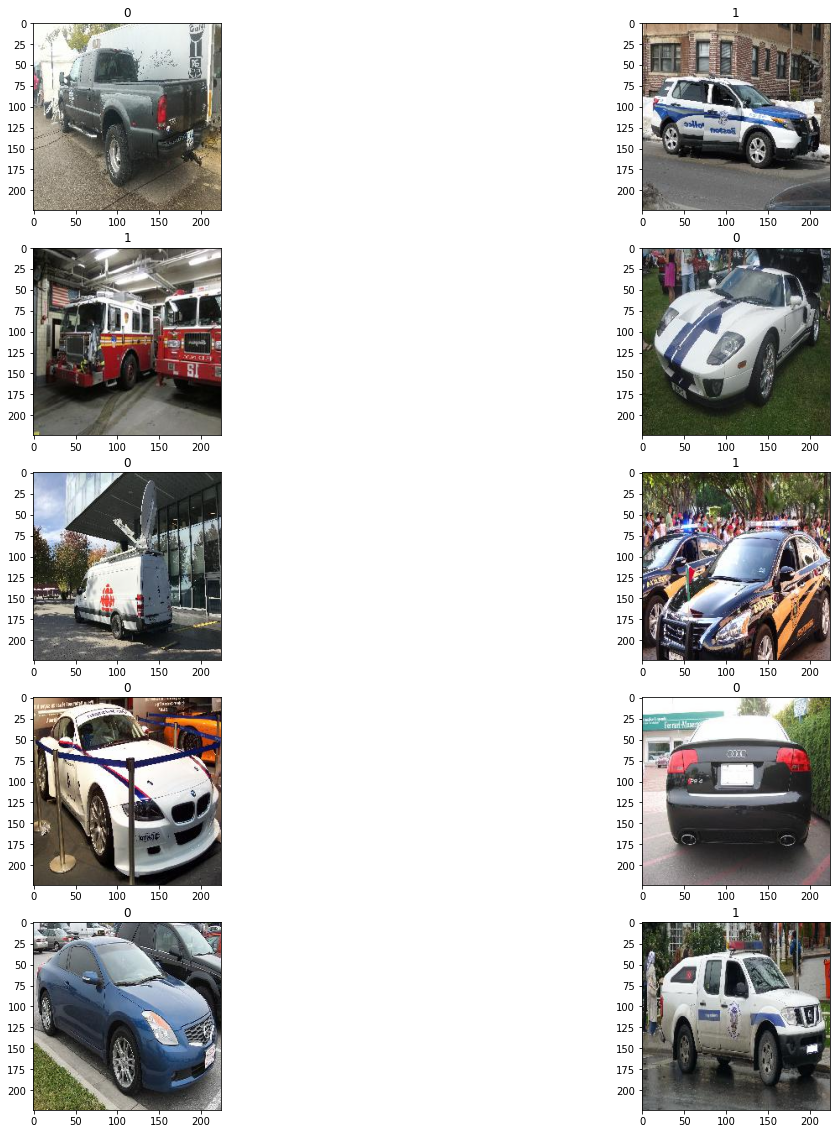

In [ ]:
plotme(train_loader)

In [ ]:
model=models.resnext101_32x8d(pretrained=True)
for p in model.parameters():
  p.requires_grad=False

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
model.fc=nn.Sequential(nn.Linear(2048,1028),
                       nn.Dropout(0.3),
                       nn.Linear(1028,512),
                       nn.ReLU(),
                       nn.Dropout(0.3),
                       nn.Linear(512,128),
                       nn.ReLU(),
                       nn.Linear(128,2))
model=model.cuda()

In [ ]:
epoches=40
lr=0.1
best_model_loss=np.inf
crit= nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = StepLR(optim, step_size=10, gamma=0.1)
test_loss=[]
train_loss=[]

for epoch in range(epoches):
  
  tl=0
  
  tstl=0
  
  print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
  model.train()

  for i,(img,labels) in enumerate(train_loader):
    img,labels=img.cuda(),labels.cuda()
    optim.zero_grad()
    op=model(img)
    loss=crit(op,labels)
    tl+=loss.item()
    loss.backward()
    optim.step()
  
  model.eval()
  for i,(img,labels) in enumerate(val_loader):
    with torch.no_grad():
      img,labels=img.cuda(),labels.cuda()
      optim.zero_grad()
      op=model(img)
      loss=crit(op,labels)
      tstl+=loss.item()
  tl=tl/len(train_loader)
  tstl=tstl/len(test_loader)
  train_loss.append(tl)
  test_loss.append(tstl)
  if tstl < best_model_loss:
    torch.save(model.state_dict(), "/content/model_lr_sch.pt")
    print("Mode saved {} to {}".format(best_model_loss,tstl))
    print("\n")
    best_model_loss=tstl
  scheduler.step()
  print("Epoch-{}/{}, train loss {}, test loss {} ".format(epoch,epoches,tl,tstl))
  print("-------------------------------------------------------------")



Epoch: 0 LR: [0.1]
Mode saved inf to 41798.0673828125


Epoch-0/40, train loss 28814.602404725552, test loss 41798.0673828125 
-------------------------------------------------------------
Epoch: 1 LR: [0.1]
Mode saved 41798.0673828125 to 649.1033935546875


Epoch-1/40, train loss 1425.3947841644288, test loss 649.1033935546875 
-------------------------------------------------------------
Epoch: 2 LR: [0.1]
Mode saved 649.1033935546875 to 4.792611360549927


Epoch-2/40, train loss 69.60638616681099, test loss 4.792611360549927 
-------------------------------------------------------------
Epoch: 3 LR: [0.1]
Epoch-3/40, train loss 2.2004501700401304, test loss 4.992954134941101 
-------------------------------------------------------------
Epoch: 4 LR: [0.1]
Mode saved 4.792611360549927 to 4.761511445045471


Epoch-4/40, train loss 0.6986438930034637, test loss 4.761511445045471 
-------------------------------------------------------------
Epoch: 5 LR: [0.1]
Mode saved 4.7615114450454

In [ ]:
model.load_state_dict(torch.load("/content/model_lr_sch.pt"))

<All keys matched successfully>

In [ ]:
model.eval()
test_pred = np.zeros((len(test_csv),))
bs=60
optim=torch.optim.Adam(model.parameters(),lr=0.01)
#model.cpu()
for i,(img,labels) in enumerate(test_loader):
  with torch.no_grad():
    img,labels=img.cuda(),labels.cuda()
    optim.zero_grad()
    op=model(img)
    pred = torch.softmax(op,1)  
    pred=pred.cpu().detach().numpy()[:,1]
    test_pred[i*bs: (i+1)*bs] = pred
    #pred = np.concatenate((np.vstack((pred)).ravel(),pred))

In [ ]:
test_pred

In [ ]:
sample_csv.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


In [ ]:
sample_csv.loc[:,"emergency_or_not"]=pred


In [ ]:
sample_csv.emergency_or_not.value_counts()

0    397
1    309
Name: emergency_or_not, dtype: int64

In [ ]:
sample_csv.to_csv("/content/submission2.csv", index=False)

In [ ]:
a=torch.randn((5,5))
b=torch.randn((5,3))
c=torch.randn((5,7))
print(a)

tensor([[-0.3961,  1.6042, -0.7044,  2.2034,  0.9313],
        [ 0.0924,  0.0277,  2.1639, -0.7401, -0.0651],
        [ 2.0262,  1.7481, -0.0316,  1.2815,  1.1334],
        [ 0.3231,  0.2987, -2.2466, -1.5265,  0.8036],
        [-0.1220, -0.4933, -0.5263, -0.2464,  1.2386]])


In [ ]:
b

tensor([[-0.0396,  1.2433,  0.8455],
        [-1.1752, -0.9746,  0.4791],
        [-0.2839,  0.5960, -2.3247],
        [-2.2972,  0.3421, -1.6282],
        [ 0.3227,  0.1247, -0.1634]])

In [ ]:
aa=[]
aa.append(np.vstack((a)).ravel())
aa.append(np.vstack((c)).ravel())

In [2]:
np.vstack((np.array(aa)))